# Understanding Conditional Expectation

Here, we are interested in determining if the estimate of: $E[Y | X]$ is improved when you have $E[Y | X, Z]$

In [13]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import os
from pathlib import Path
from pprint import pprint
import json
import collections
from itertools import combinations, chain

import numpy as np
import bnlearn as bn
import networkx as nx
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_score, recall_score
from numpy.random import Generator, PCG64
import pingouin as pg

import causal_networkx
from causal_networkx import DAG, StructuralCausalModel
from causal_networkx.ci import (
    FisherZCITest,
    GSquareCITest,
    PartialCorrelation,
    Oracle,
    ParentChildOracle,
    KernelCITest,
)
from causal_networkx.discovery import PC, RobustPC
from causal_networkx.io import read_dot, load_from_networkx
from causal_networkx.io import read_gml
from causal_networkx.metrics import (
    structure_hamming_dist,
    graph_to_pred_vector,
    confusion_matrix_networks,
)
from causal_networkx.algorithms import (
    d_separated,
    is_separating_set_minimal,
    compute_minimal_separating_set,
    moralize_graph,
)
from causal_networkx.simulation.random import extract_weights

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
%matplotlib inline

In [17]:
seed = 12345
rng = Generator(PCG64(seed))

# func_uxy = rng.uniform
func_uz = rng.uniform
func_ux = rng.uniform
func_uy = lambda: rng.uniform()  # (scale=5.0)
func_uw = lambda: rng.uniform()  # (scale=1.0)

xz_weight = 0.5
xy_weight = 2
wy_weight = 0.5

func_z = lambda u_z: u_z + rng.normal()
func_x = lambda u_x, z: u_x + xz_weight * z + rng.normal()
func_y = lambda u_y, w: wy_weight * w + u_y + rng.normal()  # + xy_weight * x
func_w = lambda u_w: u_w

scm = StructuralCausalModel(
    exogenous={
        "u_x": func_ux,
        "u_y": func_uy,
        "u_z": func_uz,
        "u_w": func_uw,
    },
    endogenous={"x": func_x, "z": func_z, "y": func_y, "w": func_w},
)

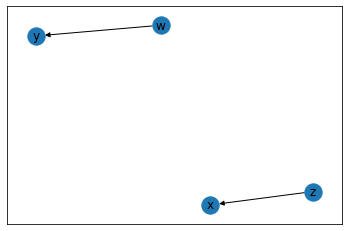

In [18]:
scm.get_causal_graph().draw()

In [47]:
n_samples = 500
df = scm.sample(n_samples)
df["noise_var"] = rng.normal(size=(n_samples,))
display(df.head())

,u_x,u_y,u_z,u_w,z,x,w,y,noise_var
0,0.227336,0.316758,0.797365,0.676255,0.722022,-0.152538,0.676255,1.303778,-0.397089
1,0.672756,0.941803,0.248246,0.948881,-0.511141,1.319384,0.948881,1.355554,-2.040687
2,0.697453,0.326473,0.733928,0.220135,2.056226,1.425868,0.220135,-1.185042,0.076578
3,0.266421,0.815776,0.193294,0.129469,1.918034,3.843598,0.129469,1.709144,1.762608
4,0.931988,0.724781,0.860551,0.929338,1.612491,1.079473,0.929338,1.447008,1.012099


In [48]:
ci_est = "fisherz"
ci_estimator = FisherZCITest()

In [49]:
stat, pvalue = ci_estimator.test(df, "x", "y")
stats = pg.partial_corr(df, x="x", y="y")

print(
    "X and Y are truly conditionally independent: ",
    stat,
    pvalue,
    stats["r"].values[0],
    stats["p-val"].values[0],
)

stat, pvalue = ci_estimator.test(df, "x", "y", "z")
stats = pg.partial_corr(df, x="x", y="y", covar=["z"])

print(
    "X and Y are truly conditionally independent: ",
    stat,
    pvalue,
    stats["r"].values[0],
    stats["p-val"].values[0],
)

stats = pg.partial_corr(df, x="x", y="y", covar=["z", "w"])
stat, pvalue = ci_estimator.test(df, "x", "y", {"z", "w"})

print(
    "X and Y are truly conditionally independent: ",
    stat,
    pvalue,
    stats["r"].values[0],
    stats["p-val"].values[0],
)

stat, pvalue = ci_estimator.test(df, "x", "y", {"noise_var"})
stats = pg.partial_corr(df, x="x", y="y", covar=["noise_var"])

print(
    "X and Y are truly conditionally independent: ",
    stat,
    pvalue,
    stats["r"].values[0],
    stats["p-val"].values[0],
)

X and Y are truly conditionally independent:  0.09491535306959217 0.9243820615900231 0.004257509729700246 0.924344242938416
X and Y are truly conditionally independent:  10.588644691486099 0.0 0.027237876413674134 0.5438278344127137
X and Y are truly conditionally independent:  10.573107407456932 0.0 0.03258186912259181 0.46817008763449275
X and Y are truly conditionally independent:  0.09613427563645409 0.9234139293432178 0.00431652959326097 0.9233755552292122


In [31]:
stat, pvalue = ci_estimator.test(df, "x", "y")
stats = pg.partial_corr(df, x="x", y="y")

print(
    "X and Y are truly conditionally dependent: ",
    stat,
    pvalue,
    stats["r"].values[0],
    stats["p-val"].values[0],
)

stat, pvalue = ci_estimator.test(df, "x", "y", "z")
stats = pg.partial_corr(df, x="x", y="y", covar=["z"])

print(
    "X and Y are truly conditionally dependent: ",
    stat,
    pvalue,
    stats["r"].values[0],
    stats["p-val"].values[0],
)

stats = pg.partial_corr(df, x="x", y="y", covar=["z", "w"])
stat, pvalue = ci_estimator.test(df, "x", "y", {"z", "w"})

print(
    "X and Y are truly conditionally dependent: ",
    stat,
    pvalue,
    stats["r"].values[0],
    stats["p-val"].values[0],
)

stat, pvalue = ci_estimator.test(df, "x", "y", {"noise_var"})
stats = pg.partial_corr(df, x="x", y="y", covar=["noise_var"])

print(
    "X and Y are truly conditionally dependent: ",
    stat,
    pvalue,
    stats["r"].values[0],
    stats["p-val"].values[0],
)

X and Y are truly conditionally dependent:  3.316197437362319 0.0009125133657337248 0.44921557705278187 0.0010663277698635904
X and Y are truly conditionally dependent:  1.9683236984300374 0.04903080489748879 0.4546442195265817 0.001031480908033459
X and Y are truly conditionally dependent:  2.0602797678247917 0.039371802958465985 0.4562635980800689 0.0011166734355438832
X and Y are truly conditionally dependent:  3.3526512023394495 0.0008004150785585473 0.45763957398380944 0.0009458300762598313


## Experiment Now Over Ratio of Dependence Strength

In [6]:
ci_est = "fisherz"
ci_estimator = FisherZCITest()

# ci_est = "parcorr"
# ci_estimator = PartialCorrelation(method="pingouin")

In [43]:
seed = 12345
rng = Generator(PCG64(seed))

result_dict = collections.defaultdict(list)

func_uz = lambda: rng.normal(scale=1.0)
func_ux = lambda: rng.normal(scale=1.0)
func_uy = lambda: rng.normal(scale=1.0)
func_uw = lambda: rng.normal(scale=1.0)  # (scale=1.0)
func_ua = lambda: rng.normal(scale=1.0)

for z_vs_x_ratio in np.linspace(0.001, 5, 500):
    z_vs_x_ratio = z_vs_x_ratio.round(4)
    # xz_weight = 1.0
    xy_weight = 0.5
    xz_weight = xy_weight * z_vs_x_ratio
    wy_weight = xy_weight  # * z_vs_x_ratio

    # instantiate the SCM
    func_z = lambda u_z: u_z  # + rng.normal()
    func_x = lambda u_x, z: xz_weight * z + u_x  # + rng.normal()
    func_y = lambda u_y, w, x: u_y + xy_weight * x  # + rng.normal()  #
    func_w = lambda u_w: u_w  # + rng.normal()
    # func_a = lambda x, u_a: x + u_a  # + rng.normal()

    scm = StructuralCausalModel(
        exogenous={
            "u_x": func_ux,
            "u_y": func_uy,
            "u_z": func_uz,
            "u_w": func_uw,
            # "u_a": func_ua,
        },
        endogenous={
            "x": func_x,
            "z": func_z,
            "y": func_y,
            "w": func_w,
            # "a": func_a
        },
    )

    # sample dataset from SCM
    # create a relatively low sample size for simple problem
    n_samples = 100
    df = scm.sample(n_samples)
    df["noise_var"] = rng.normal(size=(n_samples,))
    orig_stat, pvalue = ci_estimator.test(df, "x", "y", {})

    stat, mci_pvalue = ci_estimator.test(df, "x", "y", {"z"})
    stat, effect_mci_pvalue = ci_estimator.test(df, "x", "y", {"w"})
    stat, both_mci_pvalue = ci_estimator.test(df, "x", "y", {"z", "w"})
    stat, noise_pvalue = ci_estimator.test(df, "x", "y", {"noise_var"})

    result_dict["pvalue"].append(pvalue)
    result_dict["stat"].append(orig_stat)
    result_dict["pvalue_mci"].append(mci_pvalue)
    result_dict["pvalue_effect_mci"].append(effect_mci_pvalue)
    result_dict["pvalue_both_mci"].append(both_mci_pvalue)
    result_dict["pvalue_noise"].append(noise_pvalue)
    result_dict["weight_ratio"].append(z_vs_x_ratio)
    result_dict["z_on_x"].append(xz_weight)
    result_dict["x_on_y"].append(xy_weight)

In [44]:
df.head()

,u_x,u_y,u_z,u_w,z,x,w,y,noise_var
0,-0.346301,-0.760715,-0.826244,0.235482,-0.826244,-2.411912,0.235482,-1.966671,0.257973
1,0.405329,0.303092,-1.443759,0.354437,-1.443759,-3.204070,0.354437,-1.298943,0.651142
2,-0.561285,1.617191,-0.943123,-0.189008,-0.943123,-2.919093,-0.189008,0.157644,-0.356643
3,1.327649,0.885116,0.498299,-2.032466,0.498299,2.573396,-2.032466,2.171814,-0.623615
4,-1.078309,-0.896927,-1.144449,-1.728594,-1.144449,-3.939432,-1.728594,-2.866643,1.006582


In [51]:
result_df = pd.DataFrame.from_dict(result_dict)
display(result_df.head())

,pvalue,stat,pvalue_mci,pvalue_effect_mci,pvalue_both_mci,pvalue_noise,weight_ratio,z_on_x,x_on_y
0,1.473553e-09,6.047232,0.275118,0.526870,0.285865,4.637666e-10,0.0010,0.00050,0.5
1,3.296739e-05,4.151936,0.040508,0.455186,0.038663,2.084959e-05,0.0110,0.00550,0.5
2,4.969554e-08,5.452396,0.181612,0.578729,0.182221,7.663902e-08,0.0210,0.01050,0.5
3,1.689820e-07,5.230577,0.917140,0.820922,0.900569,1.642057e-07,0.0311,0.01555,0.5
4,2.177867e-05,4.245829,0.737809,0.523142,0.778185,2.456757e-05,0.0411,0.02055,0.5


In [46]:
print(result_df.shape)
display(result_df.head())

(500, 9)


,pvalue,stat,pvalue_mci,pvalue_effect_mci,pvalue_both_mci,pvalue_noise,weight_ratio,z_on_x,x_on_y
0,1.473553e-09,6.047232,0.275118,0.526870,0.285865,4.637666e-10,0.0010,0.00050,0.5
1,3.296739e-05,4.151936,0.040508,0.455186,0.038663,2.084959e-05,0.0110,0.00550,0.5
2,4.969554e-08,5.452396,0.181612,0.578729,0.182221,7.663902e-08,0.0210,0.01050,0.5
3,1.689820e-07,5.230577,0.917140,0.820922,0.900569,1.642057e-07,0.0311,0.01555,0.5
4,2.177867e-05,4.245829,0.737809,0.523142,0.778185,2.456757e-05,0.0411,0.02055,0.5


In [24]:
np.e ** (-5)

0.006737946999085469

<AxesSubplot:xlabel='pvalue', ylabel='Count'>

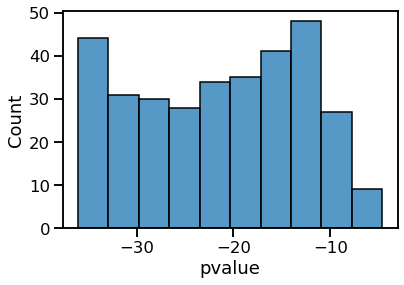

In [48]:
name = "pvalue"
result_df[name] = np.log(result_df[name])
sns.histplot(x=name, data=result_df)


KeyboardInterrupt



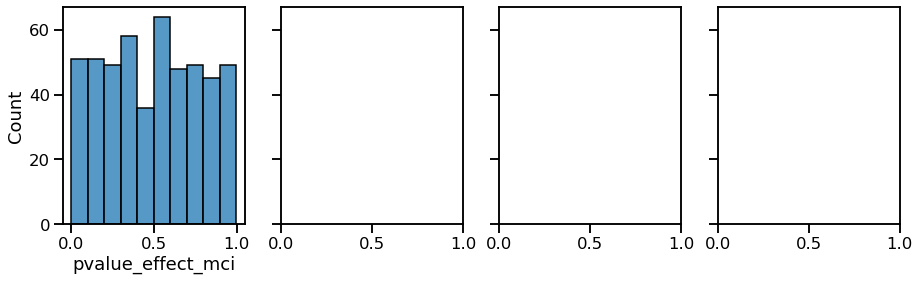

In [49]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)
axes = axes.flatten()

for idx, name in enumerate(
    ["pvalue_effect_mci", "pvalue_mci", "pvalue_both_mci", "pvalue"]
):
    sns.histplot(x=name, data=result_df, ax=axes[idx])

(500, 10)


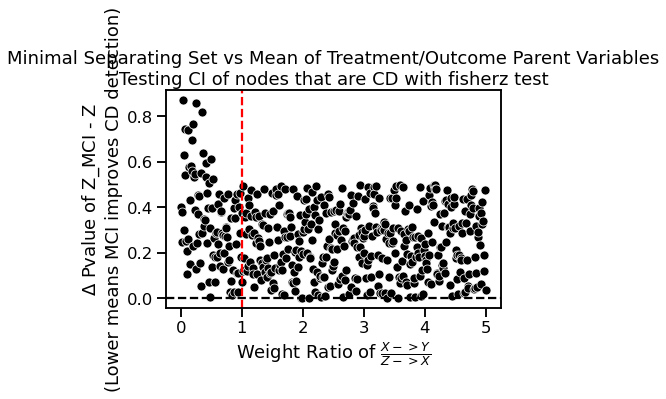

In [52]:
result_df["pvalue_diff"] = (
    result_df[["pvalue_effect_mci", "pvalue_mci"]].mean(axis=1) - result_df["pvalue"]
)

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Mean of Treatment/Outcome Parent Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

(500, 10)


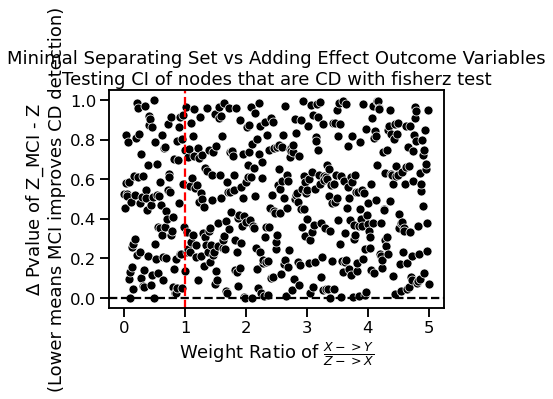

In [53]:
result_df["pvalue_diff"] = result_df["pvalue_effect_mci"] - result_df["pvalue"]

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding Effect Outcome Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

(500, 10)


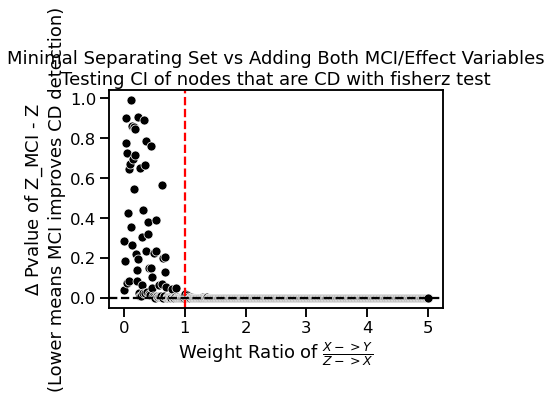

In [54]:
result_df["pvalue_diff"] = result_df["pvalue_both_mci"] - result_df["pvalue"]

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding Both MCI/Effect Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

(500, 10)


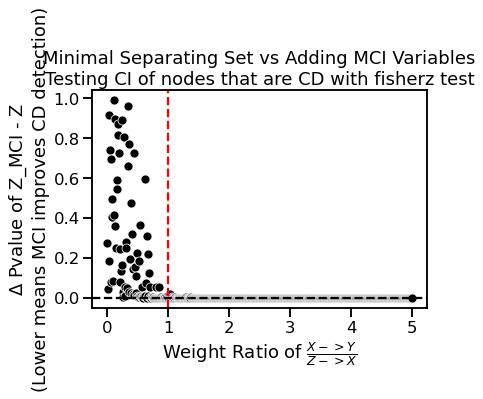

In [55]:
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue"]

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding MCI Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

# for actual CI

(500, 9)


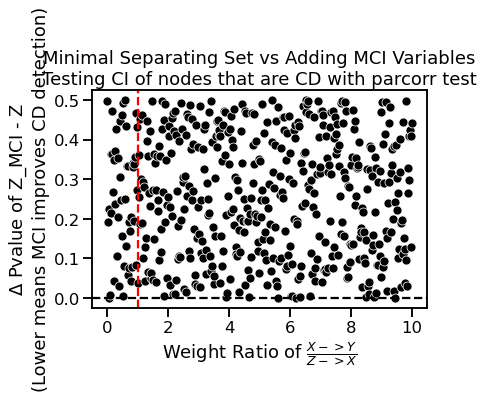

In [142]:
result_df["pvalue_diff"] = (
    result_df[["pvalue_effect_mci", "pvalue_mci"]].mean(axis=1) - result_df["pvalue"]
)

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding MCI Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

(500, 9)


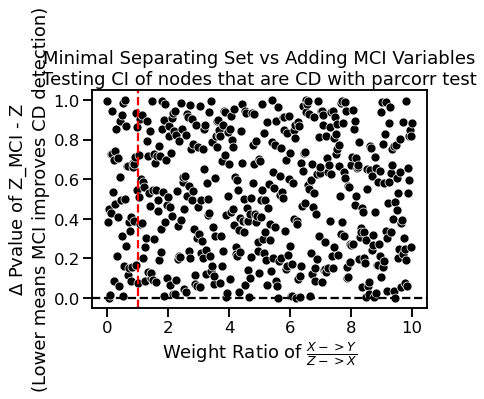

In [143]:
result_df["pvalue_diff"] = result_df["pvalue_effect_mci"] - result_df["pvalue"]

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding MCI Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

(500, 9)


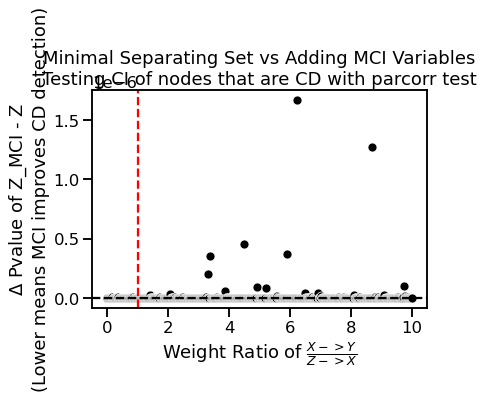

In [144]:
result_df["pvalue_diff"] = result_df["pvalue_both_mci"] - result_df["pvalue"]

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding MCI Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

(500, 9)


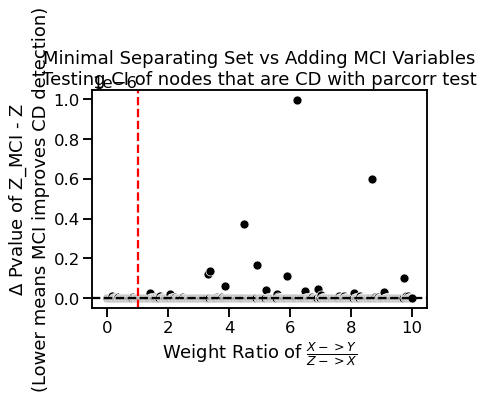

In [145]:
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue"]

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding MCI Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

# OLd

(500, 7)


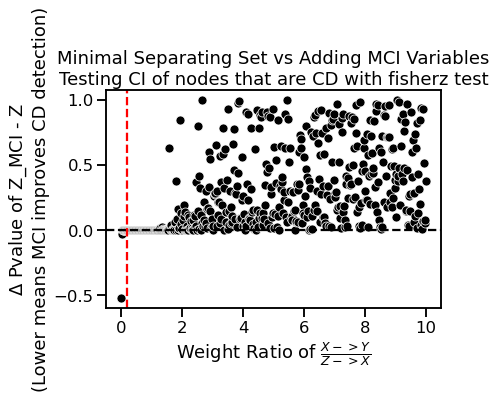

In [151]:
# var(ux) = var(uy) = 5.0, weight=4.0; all else normal
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue"]

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
# sns.boxplot(
#     x="weight_ratio",
#     y="pvalue_diff",
#     data=plot_df,
#     # color='black'
#     ax=ax,
#     boxprops=dict(alpha=0.5),
# )
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding MCI Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1 / 5], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

(500, 7)


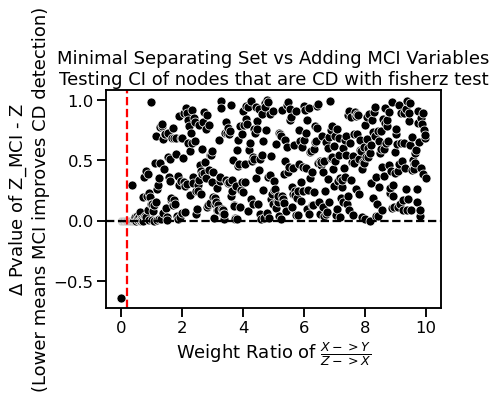

In [148]:
# var(ux) = 5.0, weight=4.0; all else normal
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue"]

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
# sns.boxplot(
#     x="weight_ratio",
#     y="pvalue_diff",
#     data=plot_df,
#     # color='black'
#     ax=ax,
#     boxprops=dict(alpha=0.5),
# )
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding MCI Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1 / 5], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

(500, 7)


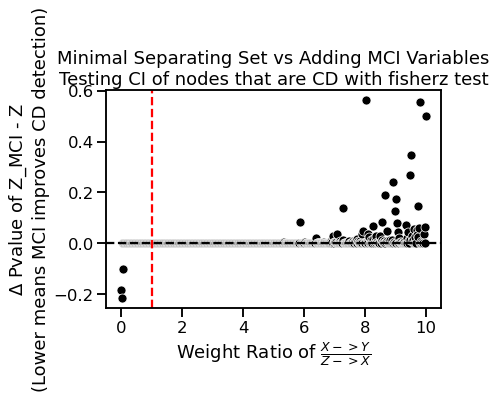

In [139]:
# var(uy) = 5.0, weight=4.0; all else normal
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue"]

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
# sns.boxplot(
#     x="weight_ratio",
#     y="pvalue_diff",
#     data=plot_df,
#     # color='black'
#     ax=ax,
#     boxprops=dict(alpha=0.5),
# )
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding MCI Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

(500, 7)


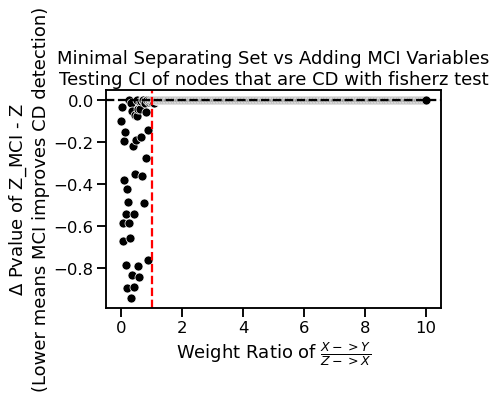

In [136]:
# var(uy) = 5.0, weight=0.5; all else normal
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue"]

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
# sns.boxplot(
#     x="weight_ratio",
#     y="pvalue_diff",
#     data=plot_df,
#     # color='black'
#     ax=ax,
#     boxprops=dict(alpha=0.5),
# )
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding MCI Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

(500, 7)


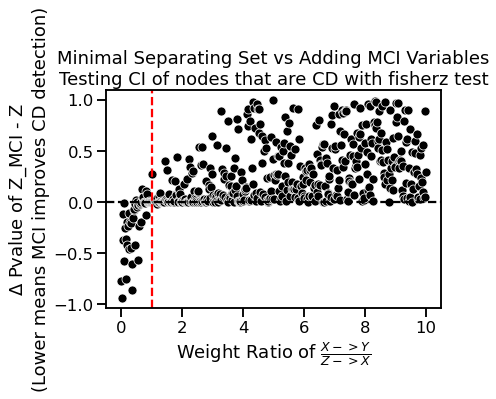

In [117]:
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue"]

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
# sns.boxplot(
#     x="weight_ratio",
#     y="pvalue_diff",
#     data=plot_df,
#     # color='black'
#     ax=ax,
#     boxprops=dict(alpha=0.5),
# )
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding MCI Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

(500, 7)


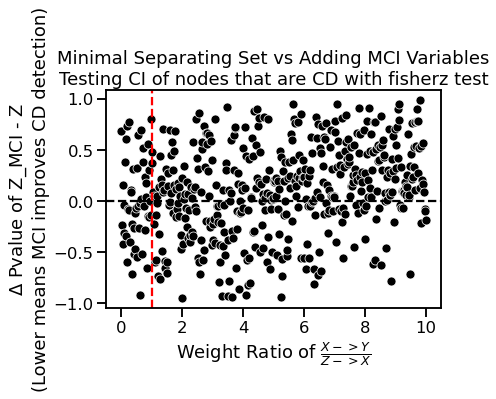

In [125]:
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue"]

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
# sns.boxplot(
#     x="weight_ratio",
#     y="pvalue_diff",
#     data=plot_df,
#     # color='black'
#     ax=ax,
#     boxprops=dict(alpha=0.5),
# )
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding MCI Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

(500, 7)


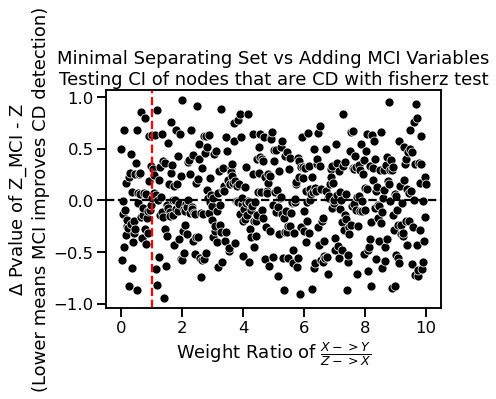

In [131]:
# 1e-5
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue"]

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
# sns.boxplot(
#     x="weight_ratio",
#     y="pvalue_diff",
#     data=plot_df,
#     # color='black'
#     ax=ax,
#     boxprops=dict(alpha=0.5),
# )
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding MCI Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")

(500, 7)


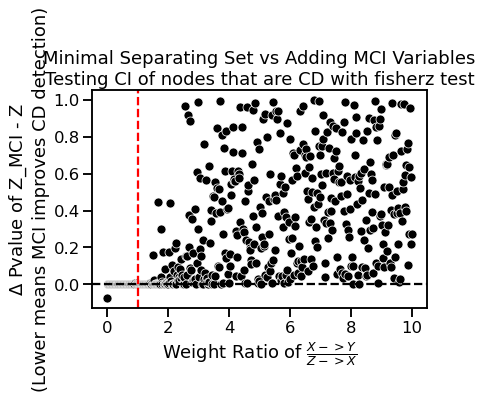

In [128]:
result_df["pvalue_diff"] = result_df["pvalue_mci"] - result_df["pvalue"]

plot_df = result_df  # [result_df["child_addition"] != set()]
print(plot_df.shape)
# plot_df = plot_df[(plot_df["pvalue_diff"].abs() > 0.00001)]
# plot_df = plot_df[(plot_df["pvalue_diff"] > 0.00001) | (plot_df["pvalue_diff"] < 0)]

sns.set_context(font_scale=1.0, context="talk")
fig, ax = plt.subplots()
sns.scatterplot(
    x="weight_ratio",
    y="pvalue_diff",
    data=plot_df,
    color="black",
    ax=ax,
)
# sns.boxplot(
#     x="weight_ratio",
#     y="pvalue_diff",
#     data=plot_df,
#     # color='black'
#     ax=ax,
#     boxprops=dict(alpha=0.5),
# )
ax.set(
    ylabel="$\Delta$ Pvalue of Z_MCI - Z\n(Lower means MCI improves CD detection)",
    xlabel=r"Weight Ratio of $\frac{X -> Y}{Z -> X}$",
    title=f"Minimal Separating Set vs Adding MCI Variables\nTesting CI of nodes that are CD with {ci_est} test",
)
ax.axhline([0], ls="--", color="black")
ax.axvline([1], ls="--", color="red")
# ax.set_xticks(ax.get_xticks()[::20])
fig.patch.set_facecolor("white")